In [ ]:
# ============================================================
# EXPERIMENT:
# (A) Condition number ONLY of Sample Covariance κ(Σ_sample)
# (B) Temporal stability ONLY on Precision matrices Θ (Sample vs Glasso)
#      using normalized Frobenius differences across contiguous windows
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings

from utility import get_data, glasso

# Optional: silence convergence warnings (Graphical Lasso)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ============================================================
# 1) CONFIG
# ============================================================
START_DATE = "2021-01-01"
END_DATE   = "2024-01-01"

POOL_SIZE = 500                 # <-- how many assets to download total
N_ASSETS  = 40                  # assets per universe
N_PLOTS   = 10                  # number of universes to show

ALPHA = 0.4
GLASSO_MAX_ITER = 500

WINDOW_WEEKS = 12
TRADING_DAYS_PER_WEEK = 5
WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK

MAX_CONDITION_NUMBER = 1e4      # threshold line ONLY for κ(Σ_sample)
MIN_COVERAGE = 0.95

RANDOM_SEED = 42
rng = np.random.RandomState(RANDOM_SEED)

print("Config loaded.")
print("  Date range:", START_DATE, "->", END_DATE)
print("  POOL_SIZE:", POOL_SIZE)
print("  N_ASSETS:", N_ASSETS)
print("  N_PLOTS:", N_PLOTS)
print("  WINDOW_SIZE:", WINDOW_SIZE)
print("  ALPHA:", ALPHA)
print("  MIN_COVERAGE:", MIN_COVERAGE)
print("  RANDOM_SEED:", RANDOM_SEED)


# ============================================================
# 2) LOAD TICKERS + DOWNLOAD RETURNS POOL
# ============================================================
ALL_TICKERS = pd.read_csv("tickers_names.csv")["Ticker"].tolist()

if POOL_SIZE > len(ALL_TICKERS):
    raise ValueError(f"POOL_SIZE={POOL_SIZE} > number of tickers in CSV ({len(ALL_TICKERS)})")

pool_idx = rng.permutation(len(ALL_TICKERS))[:POOL_SIZE]
POOL_TICKERS = [ALL_TICKERS[i] for i in pool_idx]

print("\nDownloading returns for pool (one-shot)...")
returns_pool = get_data(
    POOL_TICKERS,
    START_DATE,
    END_DATE,
    min_coverage=MIN_COVERAGE,
    fill_nan=False,
    save=False
)

print("\nreturns_pool info:")
print("  shape:", returns_pool.shape)
print("  n assets:", returns_pool.shape[1])
print("  first date:", returns_pool.index[0].date(), "| last date:", returns_pool.index[-1].date())


# ============================================================
# 3) HELPERS
# ============================================================
def split_into_windows(returns_df, window_size):
    n_samples = returns_df.shape[0]
    n_windows = n_samples // window_size
    windows = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        windows.append(returns_df.iloc[start:end])
    return windows

def frobenius_differences(mat_list, eps=1e-12):
    """
    Normalized Frobenius differences across consecutive windows:
        ||A_{t+1} - A_t||_F / ||A_t||_F
    """
    diffs = []
    for i in range(len(mat_list) - 1):
        A = mat_list[i]
        B = mat_list[i + 1]
        num = np.linalg.norm(B - A, ord="fro")
        den = np.linalg.norm(A, ord="fro")
        diffs.append(float(num / max(den, eps)))
    return np.array(diffs)

def compute_sample_covariance(window_returns):
    """
    Sample covariance computed the same way as in your original code:
    standardize -> cov -> rescale back.
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(window_returns.values)

    cov_std = np.cov(X, rowvar=False)
    s = scaler.scale_
    D = np.diag(s)

    cov = D @ cov_std @ D
    return cov

def compute_condition_numbers_sample_cov(returns_universe, window_size):
    """
    κ(Σ_sample) per window (ONLY sample covariance).
    """
    windows = split_into_windows(returns_universe, window_size)
    conds = []
    for win in windows:
        cov = compute_sample_covariance(win)
        try:
            conds.append(float(np.linalg.cond(cov)))
        except np.linalg.LinAlgError:
            conds.append(float(np.inf))
    return np.array(conds), len(windows)

def compute_precision_lists_sample_and_glasso(returns_universe, alpha, window_size, max_iter):
    """
    For temporal stability:
    build lists of Θ (precision matrices) per window:
      - sample precision: pinv(Σ_sample)
      - glasso precision: Θ_glasso from Graphical Lasso
    """
    windows = split_into_windows(returns_universe, window_size)

    sample_precs = []
    glasso_precs = []

    for win in windows:
        # --- Sample precision ---
        sample_cov = compute_sample_covariance(win)
        sample_prec = np.linalg.pinv(sample_cov)  # robust
        sample_precs.append(sample_prec)

        # --- Glasso precision ---
        g_cov, g_prec = glasso(alpha=alpha, returns_df=win, save_outputs=False, max_iter=max_iter)
        glasso_precs.append(g_prec)

    return sample_precs, glasso_precs, len(windows)


# ============================================================
# 4) SAMPLE UNIVERSI
# ============================================================
available_tickers = list(returns_pool.columns)

if len(available_tickers) < N_ASSETS:
    raise ValueError(f"Not enough tickers in returns_pool ({len(available_tickers)}) for N_ASSETS={N_ASSETS}")

universes = []
for i in range(N_PLOTS):
    tickers_i = rng.choice(available_tickers, size=N_ASSETS, replace=False)
    universes.append(tickers_i)

print("\nUniverses sampled:")
for i, u in enumerate(universes):
    print(f"  Universe {i+1}: {len(u)} assets")


# ============================================================
# 5) FIGURE A — κ(Σ_sample) ONLY (grid)
# ============================================================
ncols = 2
nrows = int(np.ceil(N_PLOTS / ncols))

figA, axesA = plt.subplots(nrows, ncols, figsize=(16, 3.6 * nrows))
axesA = np.array(axesA).flatten()

for i, tickers_i in enumerate(universes):
    ax = axesA[i]
    universe_df = returns_pool[list(tickers_i)].copy().dropna(axis=1, how="any")

    cond_sample, n_windows = compute_condition_numbers_sample_cov(universe_df, WINDOW_SIZE)
    x = np.arange(len(cond_sample))

    ax.plot(x, cond_sample, marker=".", linestyle="-", alpha=0.85, label=r"$\kappa(\Sigma_{sample})$")
    ax.axhline(MAX_CONDITION_NUMBER, linestyle="--", alpha=0.7, label=f"Threshold ({MAX_CONDITION_NUMBER:.1e})")

    ax.set_yscale("log")
    ax.set_title(f"Universe {i+1} (N={len(tickers_i)}, {n_windows} windows)")
    ax.set_xlabel("Window index")
    ax.set_ylabel(r"$\kappa(\Sigma_{sample})$")
    ax.grid(True, which="both", ls="--", alpha=0.35)

# turn off unused axes if any
for j in range(N_PLOTS, len(axesA)):
    axesA[j].axis("off")

# Global legend (clean)
handles, labels = axesA[0].get_legend_handles_labels()
figA.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

figA.suptitle("Sample Covariance Conditioning Across Random Universes (Log Scale)", y=1.06, fontsize=14)
plt.tight_layout()
plt.show()

print("Figure A generated: κ(Σ_sample) only.")



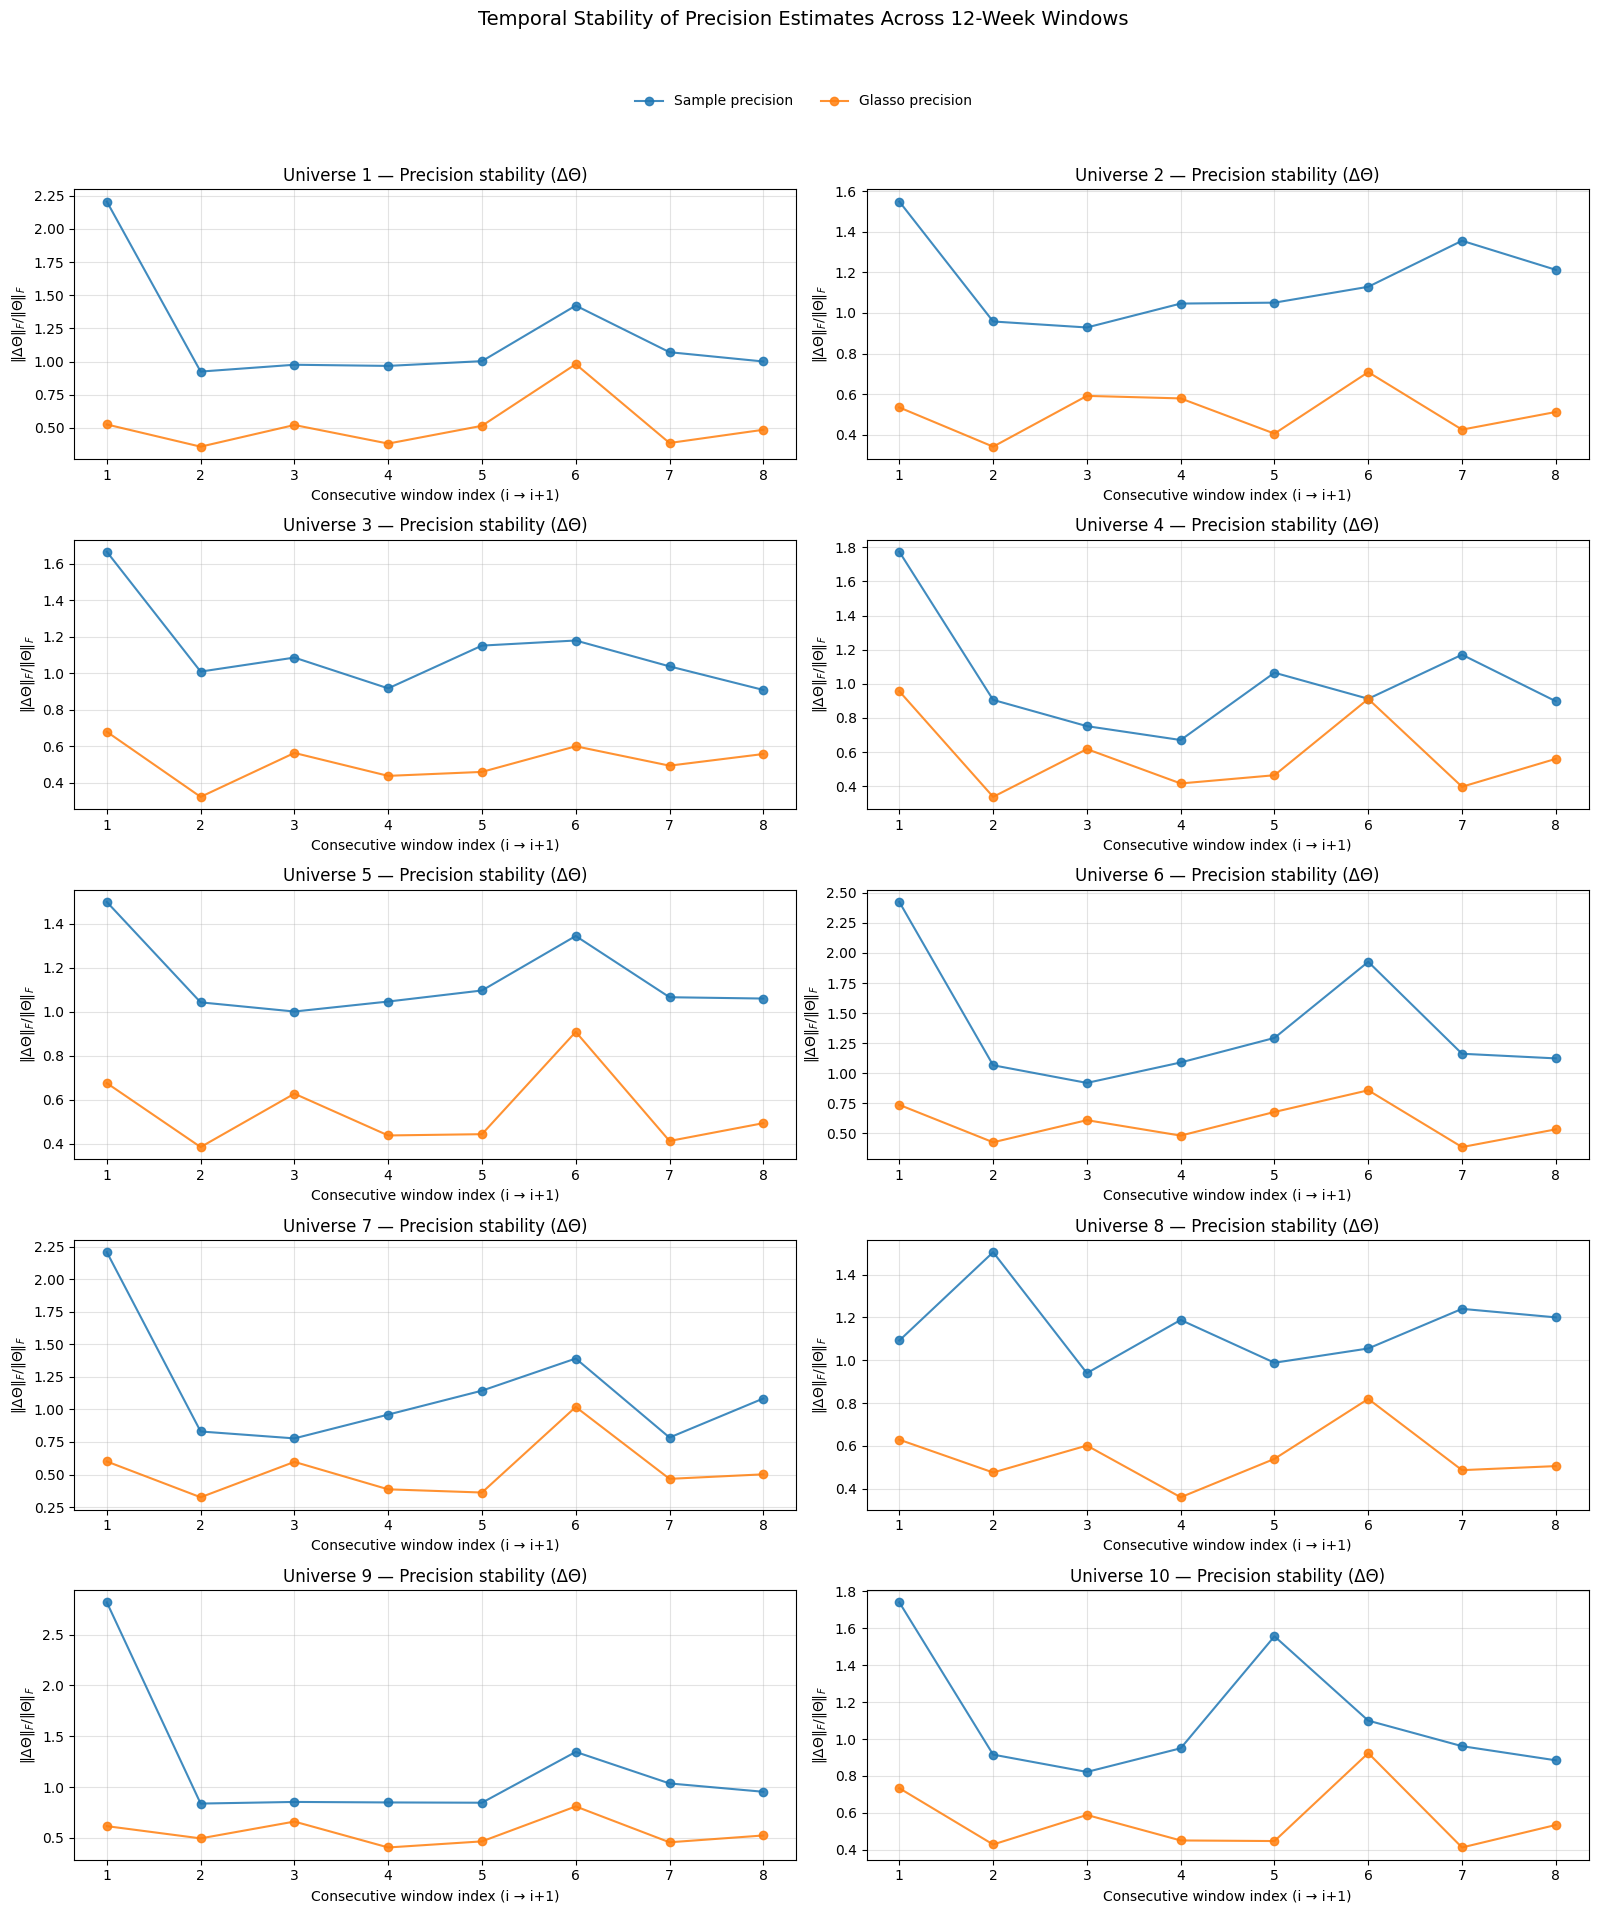

Stability statistic on precision (median of ||ΔΘ||/||Θ|| across all universes & windows):
Sample precision: 1.1614685135892722
Glasso precision: 0.5468546025183315


In [24]:
# ============================================================
# FIGURE B — Temporal stability on PRECISION ONLY (ΔΘ) (grid)
# + compute ONE stability statistic per estimator (2 numbers)
# ============================================================

figB, axesB = plt.subplots(nrows, ncols, figsize=(16, 3.6 * nrows))
axesB = np.array(axesB).flatten()

# --- NEW: collect ALL stability increments across universes ---
all_fro_sample_prec = []
all_fro_glasso_prec = []

for i, tickers_i in enumerate(universes):
    ax = axesB[i]
    universe_df = returns_pool[list(tickers_i)].copy().dropna(axis=1, how="any")

    # You already compute these -> no need to redo later
    sample_precs, glasso_precs, n_windows = compute_precision_lists_sample_and_glasso(
        universe_df, alpha=ALPHA, window_size=WINDOW_SIZE, max_iter=GLASSO_MAX_ITER
    )

    fro_sample_prec = frobenius_differences(sample_precs)
    fro_glasso_prec = frobenius_differences(glasso_precs)

    # --- NEW: store for global statistic ---
    all_fro_sample_prec.extend(fro_sample_prec.tolist())
    all_fro_glasso_prec.extend(fro_glasso_prec.tolist())

    x = np.arange(1, len(fro_sample_prec) + 1)

    ax.plot(x, fro_sample_prec, marker="o", linestyle="-", alpha=0.85, label="Sample precision")
    ax.plot(x, fro_glasso_prec, marker="o", linestyle="-", alpha=0.85, label="Glasso precision")

    ax.set_title(f"Universe {i+1} — Precision stability (ΔΘ)")
    ax.set_xlabel("Consecutive window index (i → i+1)")
    ax.set_ylabel(r"$\|\Delta\Theta\|_F / \|\Theta\|_F$")
    ax.grid(True, alpha=0.35)

# turn off unused axes if any
for j in range(N_PLOTS, len(axesB)):
    axesB[j].axis("off")

# Global legend (clean, correct placement)
handles, labels = axesB[0].get_legend_handles_labels()
figB.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

figB.suptitle(f"Temporal Stability of Precision Estimates Across {WINDOW_WEEKS}-Week Windows", y=1.06, fontsize=14)
plt.tight_layout()
plt.show()

# ============================================================
# FINAL: TWO NUMBERS (stability statistic)
# Choose a robust statistic: median stability increment across all universes/windows
# Lower = more stable
# ============================================================

all_fro_sample_prec = np.array(all_fro_sample_prec, dtype=float)
all_fro_glasso_prec = np.array(all_fro_glasso_prec, dtype=float)

stability_sample = float(np.mean(all_fro_sample_prec)) # or median
stability_glasso = float(np.mean(all_fro_glasso_prec))

print("Stability statistic on precision (median of ||ΔΘ||/||Θ|| across all universes & windows):")
print("Sample precision:", stability_sample)
print("Glasso precision:", stability_glasso)
